In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import matplotlib.pyplot as plt
plt.figure(figsize=(11, 8))
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("ufc_final.csv")
df.drop(columns=['year'], inplace=True)
#df.drop(columns = ["title_bout","R_fighter", "B_fighter", "year", "Winner", "match_no"], inplace=True)
#df=df.fillna(df.mean())

In [3]:
y = df.Won
X = df.drop('Won',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

sc_X = RobustScaler()
X_train_scaled = sc_X.fit_transform(X_train)
X_test_scaled = sc_X.transform(X_test)
X_scaled = sc_X.transform(X)

In [4]:
logit_model=sm.Logit(y,X_scaled)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.630956
         Iterations 5
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.051     
Dependent Variable: Won              AIC:              999.2674  
Date:               2019-12-14 16:49 BIC:              1101.1134 
No. Observations:   757              Log-Likelihood:   -477.63   
Df Model:           21               LL-Null:          -503.35   
Df Residuals:       735              LLR p-value:      0.00023013
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
x1         1.0510     0.2168    4.8469   0.0000    0.6260    1.4760
x2        -0.4382     0.1136   -3.8575   0.0001   -0.6609 

In [5]:
LogRegOriginal = LogisticRegression()
LogRegOriginal.fit(X_train_scaled, y_train.values.ravel())
print('Accuracy of Original Regression Model: {:}'.format(LogRegOriginal.score(X_test_scaled, y_test.values.ravel())))

Accuracy of Original Regression Model: 0.6710526315789473


In [6]:
X_trim = X.iloc[:, [0, 1, 2, 11, 17]]
X_trim_train, X_trim_test, y_train, y_test =train_test_split(X_trim, y, test_size=0.2, random_state=0)

sc_X = RobustScaler()
X_trim_train_scaled = sc_X.fit_transform(X_trim_train)
X_trim_test_scaled = sc_X.transform(X_trim_test)

LogRegRefined = LogisticRegression()
LogRegRefined.fit(X_trim_train_scaled, y_train.values.ravel())
print('Accuracy of Refined Regression Model: {:}'.format(LogRegRefined.score(X_trim_test_scaled, y_test.values.ravel())))

Accuracy of Refined Regression Model: 0.6842105263157895


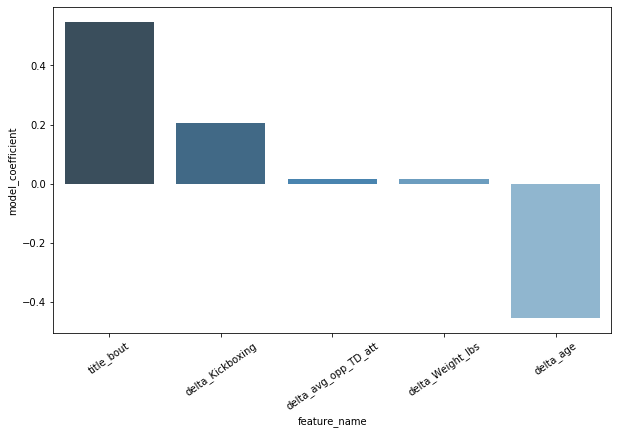

In [7]:
LogRegRefined_coeff = pd.DataFrame({'feature_name': X_trim.columns.values, 'model_coefficient': LogRegRefined.coef_.transpose().flatten()})
LogRegRefined_coeff = LogRegRefined_coeff.sort_values('model_coefficient',ascending=False)

plt.figure().set_size_inches(10, 6)
fg1 = sns.barplot(x='feature_name', y='model_coefficient',data=LogRegRefined_coeff, palette="Blues_d")
fg1.set_xticklabels(rotation=35, labels=LogRegRefined_coeff.feature_name)
plt.savefig('figure_1.png')

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

sc_X = RobustScaler()
X_train_scaled = sc_X.fit_transform(X_train)
X_test_scaled = sc_X.transform(X_test)
X_scaled = sc_X.transform(X)

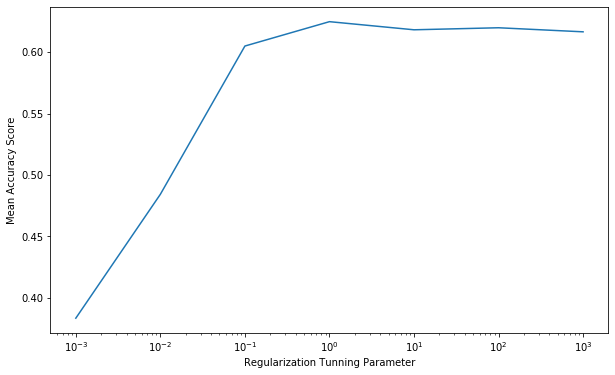

In [9]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
C_grid = {'C': C_values}
# Set the amount of folds for the cross-validation
n_folds = 5
# Do a model fit over a grid of C hyperparameters
LogRegRefined2 = LogisticRegression(penalty='l1', random_state=7)
grid_logReg = GridSearchCV(LogRegRefined2, C_grid, cv=n_folds, refit=True)
grid_logReg.fit(X_train_scaled,y_train)

# Visualize maximum accuracy
plt.figure().set_size_inches(10, 6)
plt.ylabel('Mean Accuracy Score')
plt.xlabel('Regularization Tunning Parameter')
fg3 = plt.semilogx(C_values, grid_logReg.cv_results_['mean_test_score'])
plt.savefig('figure_3.png')

In [10]:
best_logReg = grid_logReg.best_estimator_
print('Accuracy of Refined Regression Model 2: {:}'.format(best_logReg.score(X_test_scaled, y_test.values.ravel())))

Accuracy of Refined Regression Model 2: 0.6907894736842105


                       feature_name  model_coefficient
0                        title_bout           0.484903
17                 delta_Kickboxing           0.224807
20                       delta_Judo           0.173718
11             delta_avg_opp_TD_att           0.143956
7                  delta_avg_TD_att           0.112541
6          delta_avg_SIG_STR_landed           0.100007
4   delta_total_time_fought_seconds           0.096301
3                   delta_Reach_cms           0.090825
8               delta_avg_TD_landed           0.080390
21                        delta_MMA           0.056685
9         delta_avg_opp_SIG_STR_att           0.038792
15                  delta_Wrestling           0.031018
10     delta_avg_opp_SIG_STR_landed           0.022892
2                  delta_Weight_lbs           0.015806
18                     delta_Boxing          -0.013839
19                     delta_Karate          -0.079359
12          delta_avg_opp_TD_landed          -0.086173
16        

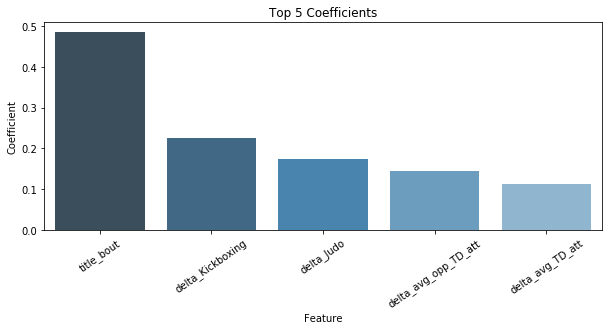

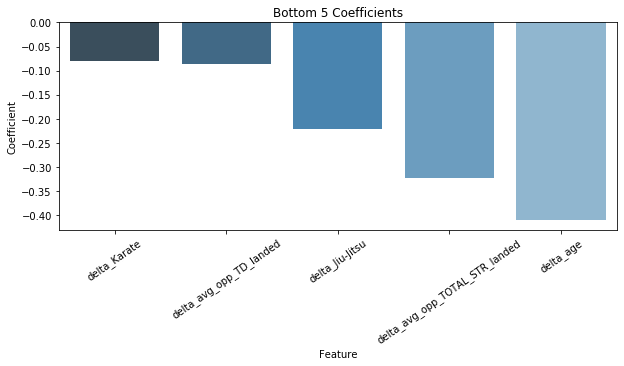

In [11]:
logReg_coeff = pd.DataFrame({'feature_name': X.columns.values, 'model_coefficient': best_logReg.coef_.transpose().flatten()})
logReg_coeff = logReg_coeff.sort_values('model_coefficient',ascending=False)
logReg_coeff_nonzero = logReg_coeff[logReg_coeff['model_coefficient'] != 0]
print(logReg_coeff_nonzero)

logRegCoeff_top = logReg_coeff_nonzero.head(5)
logRegCoeff_bottom = logReg_coeff_nonzero.tail(5)

plt.figure().set_size_inches(10, 6)
fg4 = sns.barplot(x='feature_name', y='model_coefficient',data=logRegCoeff_top, palette="Blues_d")
fg4.set_xticklabels(rotation=35, labels=logRegCoeff_top.feature_name)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Top 5 Coefficients')
plt.subplots_adjust(bottom=0.4)
plt.savefig('figure_4.png')

plt.figure().set_size_inches(10, 6)
fg5 = sns.barplot(x='feature_name', y='model_coefficient',data=logRegCoeff_bottom, palette="Blues_d")
fg5.set_xticklabels(rotation=35, labels=logRegCoeff_bottom.feature_name)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Bottom 5 Coefficients')
plt.subplots_adjust(bottom=0.4)
plt.savefig('figure_5.png')

Text(0.5, 257.44, 'Predicted label')

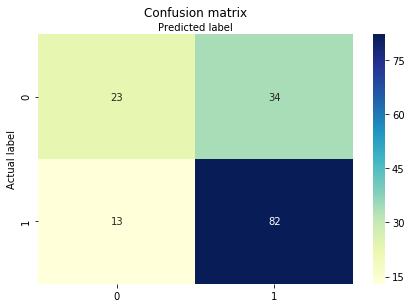

In [12]:
y_pred = best_logReg.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred) 

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5, 0, 'False Positive Rate')

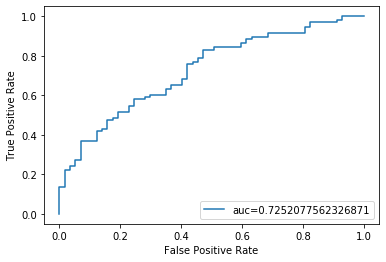

In [13]:
y_pred_proba = best_logReg.predict_proba(X_test_scaled)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [14]:
from sklearn.feature_selection import RFE
logreg = LogisticRegression()
rfe = RFE(logreg, 5)
rfe = rfe.fit(X_train_scaled, y_train.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True False False  True False False False False False False False
 False False  True False False False False False False  True]
[ 1  1 18  8  1 14 13  7 17  5  6 10 12  4  1 15  2  3 16 11  9  1]


In [15]:
X_trim = X.iloc[:, [0, 1, 4, 14, 21]]
X_trim_train, X_trim_test, y_train, y_test =train_test_split(X_trim, y, test_size=0.2, random_state=0)

sc_X = RobustScaler()
X_trim_train_scaled = sc_X.fit_transform(X_trim_train)
X_trim_test_scaled = sc_X.transform(X_trim_test)

LogRegRefined3 = LogisticRegression()
LogRegRefined3.fit(X_trim_train_scaled, y_train.values.ravel())
print('Accuracy of Refined Regression Model3: {:}'.format(LogRegRefined3.score(X_trim_test_scaled, y_test.values.ravel())))

Accuracy of Refined Regression Model3: 0.7105263157894737
